In [1]:
## Import libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd

In [2]:
## Define Basic functions ##

#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
f_scaled = lambda x, minX, maxX: f((maxX - minX)*x+minX) #only if X and not y is scaled


#squared expo kernel
def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


# Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
def posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))
    
    return Xtest, mu, std


#Same as above, but returns sigma instead of std
def posterior_full(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Known: (X,y) observations. Hyperparameters in covar funct K+sI include sigma_n, l, and sigma
    '''
    
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + (sigma_n**2)*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)
    
    return Xtest, mu, sigma


#Given test point x (Xtest_val), what is y?
def conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(np.abs(var))

    return Xtest_val, mu, std


#Given test point x (Xtest_val), what is y?
def conditional_full(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    conditional(Xtest_val, X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Given test point x (Xtest_val), what is y?
    '''
    N = len(X)
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + sigma_n**2*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)

    return Xtest_val, mu, sigma


#plot the posterior distribution of GPR
def plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma):
    '''
    plot_post(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    Plot the posterior distribution of GPR
    '''
    #Return mu and std:
    Xtest, mu, std = posterior(X, y, sigma_n, kernelParameter_l, kernelParameter_sigma)
    print("Mean predictive std: ", np.mean(std))
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f_scaled(Xtest,minX,maxX), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

## Given

Plot of dataset and the function we'd like to estimate (our goal):

0.625


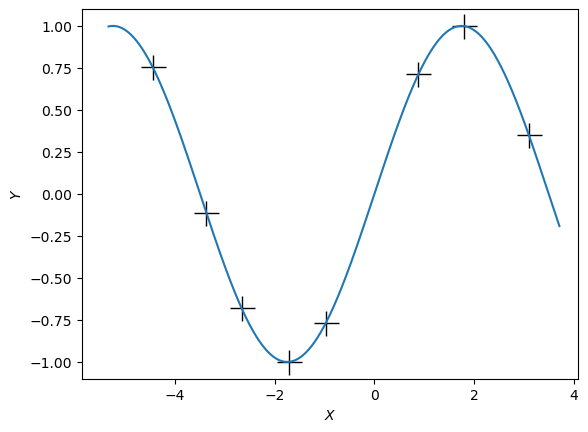

In [3]:
#This is our dataset:
Nog = 8
Xog = np.sort(generate_points(-5, 5, Nog, dim = 1),axis = 0)
#X = np.array([[0],[0.175],[0.55],[0.8],[1]])
y = (f(Xog) + np.random.normal(0,0,Nog)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot of data:
plt.plot(Xog, y, 'k+', ms=18)

#Function we'd like to estimate --> our goal
xog = np.arange(min(Xog)-abs(min(Xog))*0.2, max(Xog)+abs(max(Xog))*0.2, 0.01).reshape(-1,1)

#Render plots
plt.plot(xog, f(xog))
plt.axis([min(xog)-abs(min(xog))*0.1, max(xog)+abs(max(xog))*0.1, min(f(xog))-abs(min(f(xog)))*0.1,  max(f(xog))+abs(max(f(xog)))*0.1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

#Normalize feature: X training points, x testing points in between
minX = np.min(Xog)
maxX = np.max(Xog)
X = (Xog - minX)/(maxX - minX) #X in [0,1]

x = xog.reshape(-1,1)
x = (xog - np.min(xog))/(np.max(xog) - np.min(xog)) #X in [0,1]

#Normalize target:
#y = (y - min(y))/(max(y)-min(y))

#kernel:
K = kernel(x, x, 1, 1)

and we'll use this kernel in our GP:

We use the _Squared Exponential Kernel_, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
$$
where the signal variance $\sigma_f^2$ (signal standard deviation $\sigma_f$) and the length scale $l$ are _hyperparameters_ which we'll want to optimize. In this example, this would result in a $n$x$n$ positive-definite covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

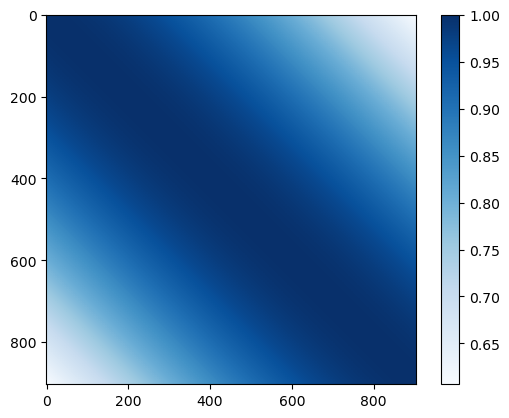

In [4]:
plt.imshow(K, cmap = 'Blues', interpolation = 'nearest')
plt.colorbar()
plt.show()

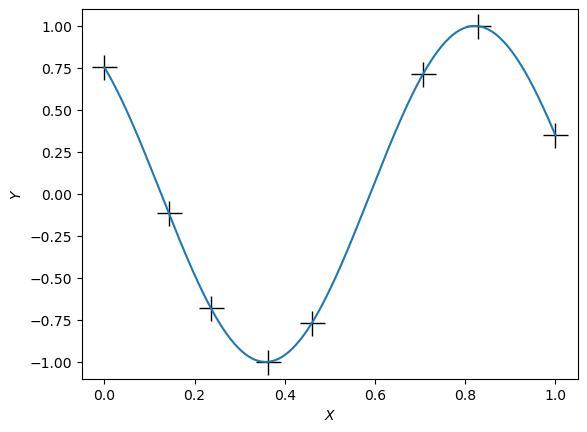

In [5]:
#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guesses

In [6]:
#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    print(ysmall)
    ysmall_x = X[ysmall_i]
    print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    print(wavelength)
    return wavelength[0]

#Initial guesses#
init_sigma_n = 0.0001 #np.std(y) # guess for observation noise
init_len_scale = wavelength(X,y)
init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations

init_par = [init_sigma_n, init_len_scale, init_sigma_f]
init_par #these are the optimum parameters

[-0.99943748]
[0.36247378]
[0.46555011]


[0.0001, 0.46555010985738887, 1.9983196506309486]

---
---
### b) Investigating 2 hyperparameters: $l$ and $\sigma_f$
Here $\theta = \{l,\sigma_f\}$ and we want to estimate the joint posterior distriubiton $P(\theta)=p(\theta\vert y,X)$

**Previous method: Finite difference method with L-BFGS-B (variation of gradient-descent method)**

Number of iterations =  18
Min of obj funct =  -1.6168053972532892
sigma_n = 0.000100, l = 0.347620, sigma_f = 1.503680
Mean predictive std:  0.0007228657907894523


<Figure size 640x480 with 0 Axes>

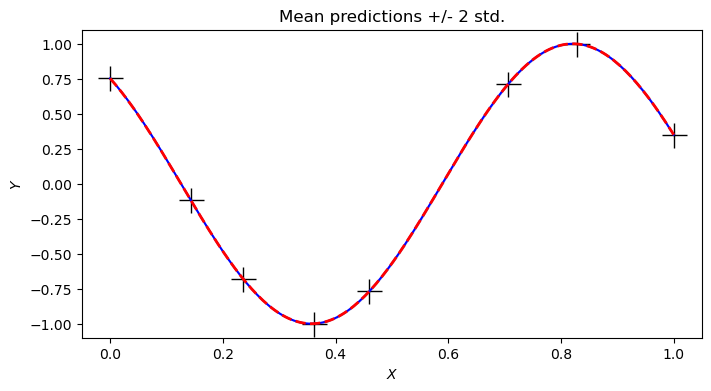

In [7]:
# Negative Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def gp_loss_fn_focus(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #negative marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return mll #this is our objective function

#--------------
#Optimize l and sigma only

#Fix unwanted hyperparameters
sigma_n = init_par[0]

#Define wrapper function to optimize l
def wrapper(params, X, y, sigma_n = sigma_n):
    l, sigma = params
    return gp_loss_fn_focus(sigma_n, l, sigma, X, y)

#Initial guess for l and sigma
params0 = [init_par[1], init_par[2]]

opt_par = minimize(wrapper, params0, args=(X,y), method="L-BFGS-B", options = {'disp':True})
print("Number of iterations = ",opt_par.nit)
sigma_n, l, sigma, z = np.abs(init_par[0]), np.abs(opt_par.x[0]), np.abs(opt_par.x[1]), opt_par.fun
print("Min of obj funct = ", z)
print("sigma_n = %f, l = %f, sigma_f = %f" % (sigma_n, l, sigma) )
plot_post(X, y.T[0], sigma_n, l, sigma)

---
**MCMC method: Metropolis-Hastings**
From before, we have the unnormalized posterior of our GP as follows
$$
p(y\vert X,\theta)p(\theta) = \tilde{P}(\theta) = \left((2\pi)^{\frac{-n}{2}}\lvert K_y\rvert^{\frac{-n}{2}}\exp[-\frac{1}{2}y^TK_y^{-1}y] \right)p(\theta)
$$
and note that
$$
\log(\tilde{P}(\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y + \log(p(\theta))
$$
<br>
For multiple hyperparameters where each hyperparameter has its own prior distribution, our prior $p(\theta)$ is a joint prior where $\theta = [\theta_1,\theta_2,\ldots,\theta_d]$ for $d$ hyperparameters. Assuming each hyperparameter is mutually independent, we can define our joint prior distriubiton as a factorization of each individual prior as such:
$$
p(\theta) = \prod_{i=1}^dp(\theta_i)
$$
Thus, the Metropolis-Hastings method of MCMC looks the same whether we're dealing with one or multiple parameters.

In [8]:
#Marginal log-likelihood of the GP we would like to optimize (modified to allow focus on particular hyperparams)
def log_like(sigma_n, l, sigma, X, y): #input observations (X,y) and initial parameters (guess)
    N = len(X)
    
    K_y = kernel(X, X, l, sigma) + (sigma_n**2)*np.eye(N)
    K_y_inverse = np.linalg.inv(K_y)
    
    #marginal log-likelihood
    mll = (N/2)*np.log(2*np.pi) + (1/2)*np.log(np.linalg.det(K_y)) + (1/2)*np.dot(np.dot(y.T,K_y_inverse),y)
    return -1*mll

#-----------------
#MCMC MH implementation to optimize l and sigma only
def mcmc_lsigma(a,b,N,fixed_par,target_par,X,y,og = True,density = None):
    '''
    a = [a_l, a_simga, ...] is an array of the lower bounds of the MCMC search
    b = [b_l, b_sigma, ...] is an array of the upper bounds of the MCMC search
    fixed_par = [*,*,...] is an array of the initial values of the parameters that won't change (like sigma_n)
    target_par = [*,*,...] is an array of the initial values of the target parameters (like l and sigma)
    X is the feature variable
    y is the response
    og = original MCMC (first level of Bayesian update)
    '''
    

    #Define priors
    def log_prior(target):
        '''
        target_i is an iterate of the target array [l, sigma, ...]
        a_i is an iterate of the array a
        b_i is an iterate of the array b
        '''
        logval = 0
        for i in range(len(target)):
            if (target[i] <= a[i] or target[i] >= b[i]):
                value = 0.00001
            else:
                if og == True:
                    value = 1 #/target[i] #change for Jeffreys prior
                else:
                    value = pdf_post(target[i],density)
            logval = logval + np.log(value+0.00001)
        return logval


    l = np.zeros(N)
    sigma = np.zeros(N)
    l[0] = target_par[0]
    sigma[0] = target_par[1]

    #Fix unwanted hyperparameters
    sigma_n = fixed_par[0]
    
    accept_count = 0
    for i in range(1, N):
        #1) Propose new position theta[i-1] -> theta[i]' by sampling from proposal distro
        l_prop = np.random.uniform(a[0], b[0]) #l[i]'
        sigma_prop = np.random.uniform(a[1],b[1])
        target_prop = [l_prop, sigma_prop]

        #2) Compute log of acceptance ratio
        prop = log_like(sigma_n, l_prop, sigma_prop, X, y) + log_prior(target_prop)
        target_prev = [l[i-1], sigma[i-1]]
        prev = log_like(sigma_n, l[i-1], sigma[i-1], X, y) + log_prior(target_prev)

        log_alpha = min(prop - prev, 0)  # Acceptance ratio

        #3) Generate a random number u_i from [0,1]
        u = np.random.uniform(0,1) #u_i

        #4)
        if u <= np.exp(log_alpha) and 0 < l_prop and 0 < sigma_prop:
            # Accept y as next state
            l[i] = l_prop 
            sigma[i] = sigma_prop
            accept_count = accept_count + 1
        else:
            # Stay at previous state of Markov chain
            l[i] = l[i-1]
            sigma[i] = sigma[i-1]
            
    #--- Returns ---
    ##
    accept_rate = accept_count/N #acceptance rate
    n = int(0.95*N) #number of samples of the posterior
    C = l[-n:] #samples of the posterior
    D = sigma[-n:]
    ##

    #Freedman-Diaconis rule for determining bin width
    nbins = int(np.ceil((np.max(C)-np.min(C))/(2*stats.iqr(C)*n**(-1/3))))

    #KDE estimate of posterior density pdf:
    #for pdf, add .pdf([array points you want to evaluate]) to end of density 
    density_C = stats.gaussian_kde(C, bw_method='scott')
    eval_points_C = np.linspace(np.min(C), np.max(C), num=1000)
    dc_C = (np.max(eval_points_C)-np.min(eval_points_C))/999
    max_post_l = eval_points_C[np.argmax(density_C.pdf(eval_points_C))] #MAP_C
    
    density_D = stats.gaussian_kde(D, bw_method='scott')
    eval_points_D = np.linspace(np.min(D), np.max(D), num=1000)
    dc_D = (np.max(eval_points_D)-np.min(eval_points_D))/999
    max_post_sigma = eval_points_D[np.argmax(density_D.pdf(eval_points_D))] #MAP_D
    
    ##
    posteriors = [C, D]
    densities = [density_C, density_D]
    eval_points = [eval_points_C, eval_points_D]
    dc = [dc_C, dc_D]
    MAPs = [max_post_l, max_post_sigma]
    ##
    
    return posteriors, densities, eval_points, dc, MAPs, n, nbins, accept_rate

In [9]:
#Initials
a_l = 0.00001
b_l = 10
a_sigma = 0.00001
b_sigma = 5

a = [a_l, a_sigma]
b = [b_l, b_sigma]
N = 20000
fixed_par = [init_par[0]]
target_par = [init_par[1], init_par[2]]

posteriors, densities, eval_points, dc, MAPs, n, nbins, accept_rate = mcmc_lsigma(a,b,N,fixed_par,target_par,X,y,og = True,density = None)

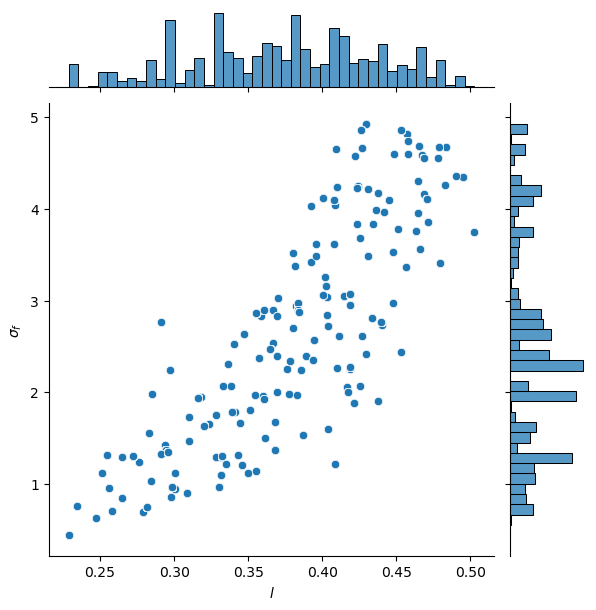

In [10]:
#Distribution of l and sigma
C, D = posteriors[0], posteriors[1]
sns.jointplot(x=C,y=D, kind='scatter')
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

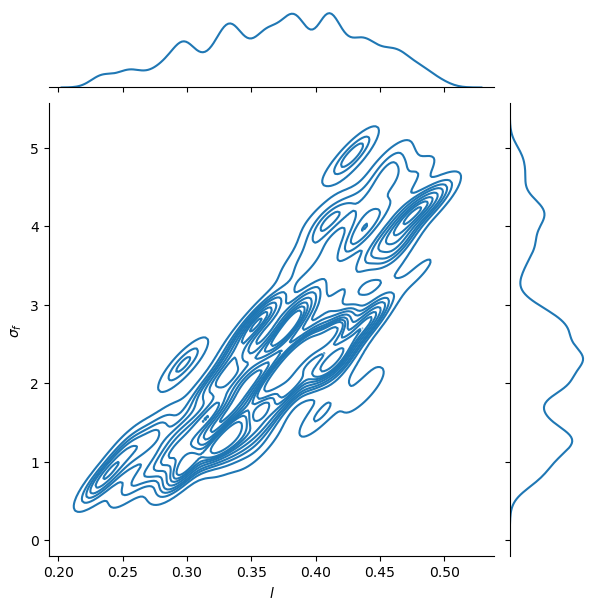

In [11]:
#Distribution of l and sigma
sns.jointplot(x=C,y=D, kind='kde')
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

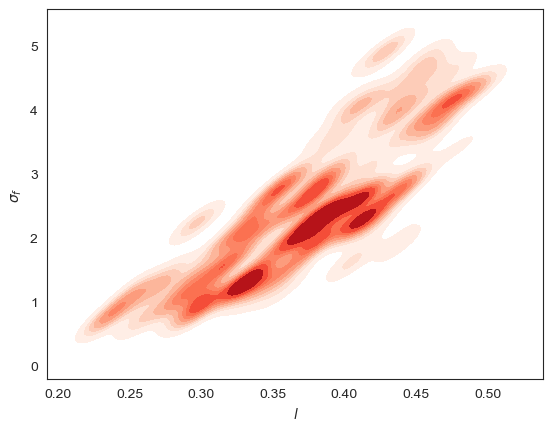

In [12]:
sns.set_style("white")
sns.kdeplot(x=C, y=D, cmap="Reds", fill=True)
plt.xlabel(r'$l$')
plt.ylabel(r'$\sigma_f$')
plt.show()

In [13]:
#MAPs of l and sigma
print("MAPs of l and sigma: ",MAPs[0]," ,",MAPs[1])

MAPs of l and sigma:  0.4105867729067172  , 2.3061957096476284


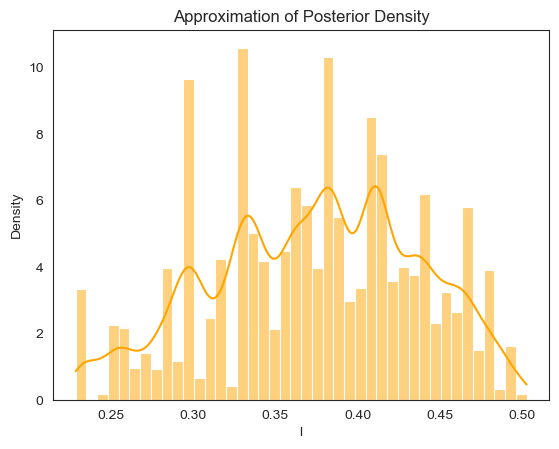

In [14]:
# Plot of MCMC approximation of the posterior
sns.histplot(C, kde=True, bins = nbins, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

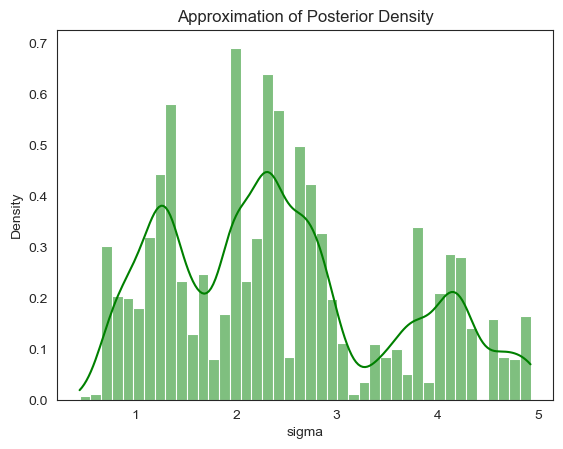

In [15]:
# Plot of MCMC approximation of the posterior
sns.histplot(D, kde=True, bins = nbins, color="green", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()